Dans ce projet, je réalise une étude de l'équation de Poisson qui est donnée par :

Trouver $u$ tel que :

$$
-\Delta u = f \quad \text{dans} \quad \Omega
$$

avec la condition aux limites :

$$
u_{\Gamma} = 0
$$

La formulation variationnelle est la suivante : 

Il existe $u \in H_{0}^{1}(\Omega)$ tel que

$$
\int_{\Omega} \nabla u \cdot \nabla v \, d \omega=\int_{\Omega} f v \, d \omega \quad \forall v \quad \text{tel que} \quad v \in H_{0}^{1}(\Omega)
$$

Dans le fichier `GmeshRead.py`, il y a une classe qui lit les maillages que j'ai discrétisés. Elle parcourt tous les éléments et tous les nœuds. J'ai déclaré des dictionnaires et des listes pour stocker différentes informations de `carre.msh`.

In [1]:
from scipy.sparse import bmat
from scipy.sparse import csc_matrix
import numpy as np
from scipy.sparse import dok_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
# l'appel de la fonction mesh2d du module GmeshRead pour le carré 
from GmeshRead import mesh2d
mesh = mesh2d("./maillage/cavity.msh")

In [3]:
mesh.process()
connectivité = mesh.connect
print(connectivité[0,0])

1


In [4]:
bord = mesh.get_border_points_by_name("bord")
print("Points de bord 'bord':", bord)

Points de bord 'bord': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]


In [5]:
left_points = mesh.get_border_points_by_name("PuitsInj")
coords_left = [mesh.coords[i] for i in left_points]
print("Coordonnées des points de bord 'Left':", coords_left)

Nom de bord 'PuitsInj' non trouvé.
Coordonnées des points de bord 'Left': []


In [6]:
points_list = mesh.border_liness()
print("Liste des lignes de bord:", points_list)

Liste des lignes de bord: [[1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2], [2, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 3], [3, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 4], [4, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 1]]


## Base de l&#8217;élément fini P1.

Considérons le triangle de sommets $a_{1}=(0,0), a_{2}=(1,0)$ et $a_{3}=(0,1),$ comme éléments de références.
La base d&#8217;élément fini associé à chacun de ces points est donnée par:

$$
\psi_{1}(x, y)=1-(x+y), \quad \psi_{2}(x, y)=x, \quad \psi_{3}(x, y)=y
$$
* **Q1**\
Créer une fonction `coord(1d)` qui prend en entrée un tableau de taille 3 contenant les coordonnées barycentriques $\left(\lambda_{1}, \lambda_{2}, \lambda_{3}\right)$ d&#8217;un point et renvoie le tableau de taille 2 contenant les coordonnées de ce point:

  
$$
(x, y)=\lambda_{1} a_{1}+\lambda_{2} a_{2}+\lambda_{3} a_{3}
$$




In [7]:
def coord(lambdas):

    # Définir les sommets du triangle
    a = np.array([[0, 0], [1, 0], [0 , 1]])

    return np.dot(lambdas, a)
# condition la somme des lambdas doit être égale à 1
t=coord([1, 0, 0])
t

array([0, 0])

* **Q2**\
Nous souhaitons créer une fonction `base_psiref()`` qui permettra d&#8217;effectuer les quadratures
sur l&#8217;élément de référence. Cette fonction doit renvoyer les quatre tableaux suivants:




In [8]:
def basis_psiref():
    # Coordonnées barycentriques des points de quadrature
    pts = np.array([
        [1/3, 1/3, 1/3],
        [1/2, 1/2, 0],
        [0, 1/2, 1/2],
        [1/2, 0, 1/2],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ])

    # Poids de quadrature associés
    wght = np.array([9/40, 2/30, 2/30, 2/30, 1/40, 1/40, 1/40])

    # Valeur des 3 fonctions de base aux 7 points de quadrature
    psi = np.array([
        [1 - coord(pt)[0] - coord(pt)[1] for pt in pts],
        [coord(pt)[0] for pt in pts],
        [coord(pt)[1] for pt in pts]
    ])

    # Valeur des gradients des 3 fonctions de base aux 7 points de quadrature
    derpsi = np.array([
        [[-1, -1] for _ in pts],
        [[1, 0] for _ in pts],
        [[0, 1] for _ in pts]
    ])

    return pts, wght, psi, derpsi
pts, wght, psi, derpsi = basis_psiref()
#print(2*wght)
#print(pts)
#print(wght)
#print(psi)
#print(derpsi[0,0])

## Assemblage de la matrice.

* **Q1**\
Créer une `class poisson` qui contient un prend à la contruction en entrée un maillage `Mh` et une fonction, `f`, correspondant au second membre de l&#8217;équation. Un élément de la classe contiendra de plus `Ndof`, le nombre de degrés de liberté (correspondant au nombre de noeuds du maillage), une matrice de taille `(Ndof,Ndof)`, stockée intialement au format [dok](https://scipy-lectures.org/advanced/scipy_sparse/dok_matrix.html), un tableau `rhs` de taille `Ndof`, contenant le second membre du système linéaire et enfin un tableau u de taille `Ndof` contenant la solution approchée.


In [9]:
class Poisson:
    def __init__(self, Mh, f):
        self.Mh = Mh
        self.f = f
        self.Ndof = Mh.Nnodes  # Nombre de noeuds du maillage
        print("nodes", self.Ndof)
        self.M = dok_matrix((self.Ndof, self.Ndof), dtype=np.float64)  # Matrice A
        self.D = dok_matrix((self.Ndof, self.Ndof), dtype=np.float64)
        self.rhs = np.zeros(self.Ndof)  # Second membre du système linéaire
        self.B = np.zeros(self.Ndof)  # Second membre du système linéaire
        self.O = np.zeros(self.Ndof)  # Second membre du système linéaire
        self.u = np.zeros(self.Ndof)  # Solution approchée
    def assemble_matrix(self):
        pts, wght, psi, derpsi = basis_psiref()
        for nel in range(self.Mh.Nel):
            self.K = np.zeros((3,3), dtype=np.float64) 
            self.L = np.zeros((3,3), dtype=np.float64)
            A = self.Mh.coords[self.Mh.nodes[nel,0]] # noeuds du triangle
            E = self.Mh.coords[self.Mh.nodes[nel,1]]
            C = self.Mh.coords[self.Mh.nodes[nel,2]]
            Jac = np.array([[E[0] - A[0], C[0] - A[0]],[E[1] - A[1], C[1] - A[1]]]) # Jacobien de l'élément
            #print('jac',Jac)
            detT = np.linalg.det(Jac) # det(T_K)
            #print(detT)
            comT = np.linalg.inv(Jac.T)  # det(T_K) * (nabla (T_K))^{-1} = com(T_{K})^{-1}
            #print('comT',comT)
            # print(f"Element {nel}:")
            # print(f"Jacobian:\n{Jac}")
            # print(f"detT: {detT}")
            # print(f"comT:\n{comT}")
            for i, wgh in enumerate(wght):
                for ni in range(3):
                    inode = self.Mh.connect[nel, ni] - 1
                    dpsi_i = np.dot(comT, derpsi[ni,i]) # Calculer le gradient de psi pour le noeud i
                    for nj in range(3):
                        self.K[ni, nj] += wgh *detT* np.dot(psi[nj,i],psi[ni,i])
                        jnode = self.Mh.connect[nel, nj] - 1
                        dpsi_j = np.dot(comT,derpsi[nj,i])  # Calculer la dérivée de psi pour le noeud j
                        self.L[ni,nj] += wgh *detT* np.dot(dpsi_i,dpsi_j)
                        self.M[inode, jnode] += wgh *detT* np.dot(dpsi_i,dpsi_j) 
                        self.D[inode, jnode] += wgh *detT* np.dot(psi[nj,i],psi[ni,i])
            # print("L",self.L)
        self.M = self.M.tocsc() # Convertir la matrice A au format CSC pour des calculs plus efficaces
        self.D = self.D.tocsc()
        self.K = self.K
        self.L = self.L
     #######################################################
     # https://perso.univ-lyon1.fr/marc.buffat/COURS/BOOK_ELTFINIS_HTML/CoursEF/Notebook/EltFinis2D/Laplace2D.html
     # Une deuxième méthode pour calculer le terme droite B sans utiliser les quadratures    
    def Smb(self,Mh,F):
        self.Ndof = Mh.Nnodes
        for k in range(self.Mh.Nel):
            Me = self.K
            ni = [self.Mh.connect[k, 0] - 1,self.Mh.connect[k, 1] - 1,self.Mh.connect[k, 2] - 1]
            Fe=F[np.ix_(ni)]
            self.B[np.ix_(ni)] += np.dot(Me,Fe)
    
    ########################################################
    # Une fonction pour calculer la fonction u sur le bord du domaine dans les cas qu'on a des condition differentes de 0
    def BordG(self,Mh,G):
        self.Ndof = Mh.Nnodes
        for k in range(self.Mh.Nel):
            Me=self.K
            ni = [self.Mh.connect[k, 0] - 1,self.Mh.connect[k, 1] - 1,self.Mh.connect[k, 2] - 1]
            Fe=G[np.ix_(ni)]
            self.O[np.ix_(ni)] += np.dot(Me,Fe)
    ########################################################     
    # une fonction qui calcule la norme en L^2 grace a ca definition
    # int_omega f^2 dx = sum_{K =1 to Nel} int_K f^2 dx     
    def intL2(self,F):
    #calcul integrale L2 d'une fonction F sur un maillage G 
        somme=0.0
        for k in range(self.Mh.Nel):
            Me = self.K
            ni = [self.Mh.connect[k, 0] - 1,self.Mh.connect[k, 1] - 1,self.Mh.connect[k, 2] - 1]
            Fe = F[np.ix_(ni)]
            somme += np.dot(Fe,np.dot(Me, Fe))
        return somme
    ########################################################
    # trace de la solution et l'erreur
    # une autre methode pour tracer la solution et l'erreur 
    def trace(self,U,Uex):
        x = np.array([coord[0] for coord in mesh.coords.values()])
        y = np.array([coord[1] for coord in mesh.coords.values()])
        plt.figure(figsize=(12,5))
        plt.subplot(1,3,1)
        plt.axis('equal'); plt.axis('off')
        plt.tricontourf(x, y, U, levels=14, cmap='viridis')
        plt.colorbar(label='U')
        plt.title("Solution EF")
        plt.subplot(1,3,2)
        plt.axis('equal'); 
        plt.axis('off')
        plt.tricontourf(x, y, Uex, levels=14, cmap='viridis')
        plt.colorbar(label='U')
        plt.title("Exact")
        plt.subplot(1,3,3)
        plt.axis('equal'); 
        plt.axis('off')
        plt.tricontourf(x, y, Uex - U, levels=14, cmap='viridis')
        plt.colorbar(label='U')
        plt.title("Erreur")
        plt.show()
        return
    
    #############################################################
    # La méthode qui calcule le seconde terme par la methode des quadratures 
    def rhss(self):
        pts, wght, psi, derpsi = basis_psiref()
        for nel in range(self.Mh.Nel): 
            A = self.Mh.coords[self.Mh.nodes[nel,0]] # noeuds du triangle
            B = self.Mh.coords[self.Mh.nodes[nel,1]]
            C = self.Mh.coords[self.Mh.nodes[nel,2]]
            Jac = np.array([[B[0] - A[0], C[0] - A[0]],[B[1] - A[1], C[1] - A[1]]]) # Jacobien de l'élément
            detT = np.linalg.det(Jac) # det(T_K)
            for i, wgh in enumerate(wght):
                for ni in range(3):
                    inode = self.Mh.connect[nel, ni] - 1 
                    self.rhs[inode] += wgh   *detT * self.f(coord(pts)[i,0], coord(pts)[i,1]) * psi[ni,i]
    #############################################################
    # ajoute les conditions de Neumann
    def neuemann_conditions(self,Mh,cond):
        
        self.M = self.M.toarray()
        self.D = self.D.toarray()
        self.Ndof = Mh.Nnodes
        nb = len(mesh.neudes_bord)
        for i in [node-1 for node in mesh.neudes_bord]:
            self.M[i, :i] = 0
            self.M[i, i+1:] = 0
            self.D[i, :i] = 0
            self.D[i, i+1:] = 0
            self.M[:i, i] = 0
            self.M[i+1:, i] = 0
            self.D[:i, i] = 0
            self.D[i+1:, i] = 0
            # self.M[i, i] = 1
            # self.D[i, i] = 1
            # on elimine cette point noramalement car au ce ponts la n'apparient pas a la frontiere triangule (0,0) juste la discretisation qui l'ajoute dans le cas ou on a disque 
            self.M[1,1] = 1
            self.D[1,1] = 1
        for j in range(nb,self.Ndof):
            self.O[j] = 0
        
        if cond =='homogene':
            for i in [node-1 for node in mesh.neudes_bord]:
                self.B[i] = self.B[i]
                self.rhs[i]= self.rhs[i]
        else:
            for i in range(self.Ndof):
                self.B[i] = self.B[i] + self.O[i]
        
        
#############################################################"
# ajoute les conditions de Dirichlet
    # def dirichlet_conditions(self):
    #     self.M = self.M.toarray()
    #     self.D = self.D.toarray()
    #     for i in [node-1 for node in mesh.neudes_bord]:
    #         self.M[i, :] = 0
    #         # self.D[i, :] = 0
    #         self.M[:, i] = 0
    #         # self.D[:, i] = 0
    #         self.M[i, i] = 1
    #         # self.D[i, i] = 1
    #         self.rhs[i] = 0
    #         self.M[1,1] = 1
    #         # self.D[1,1] = 1
    #         self.B[i] = 0
    def conditions_on_borders(self, border_types):
    # """
    # Applique les conditions de Dirichlet ou Neumann sur les bords.
    # border_types : dictionnaire {nom_bord: ("dirichlet" ou "neumann", valeur)}
    # Exemple : {"Left": ("dirichlet", 0), "Right": ("neumann", g)}
    # """
        self.M = self.M.toarray()
        self.D = self.D.toarray()
        for border_name, (cond_type, value) in border_types.items():
            border_points = self.Mh.get_border_points_by_name(border_name)
            if cond_type == "dirichlet":
               for i in [node-1 for node in border_points]:
                   self.M[i, :] = 0
                   self.M[:, i] = 0
                   self.M[i, i] = 1
                   self.rhs[i] = 0
                   self.B[i] = 0
            elif cond_type == "neumann":
            # Pour Neumann homogène, rien à faire (déjà pris en compte)
            # Pour Neumann non homogène, ajouter la contribution au second membre
            # value = g(x) (flux imposé sur le bord)
               for i in [node-1 for node in border_points]:
                   self.rhs[i] += value  # ou intégrer g(x) sur le bord si besoin

    ########################################################
    # plot de la solution
    def plot_sol(self,sol):
        x = np.array([coord[0] for coord in mesh.coords.values()])
        y = np.array([coord[1] for coord in mesh.coords.values()])
        fig = plt.figure()
        ax = fig.add_subplot(111,projection='3d')
        surf = ax.plot_trisurf(x, y, sol, linewidth=0.2, antialiased=True, cmap=plt.cm.CMRmap)
        fig.colorbar(surf, shrink=0.5, aspect=5)
        plt.figure()
        plt.tricontourf(x, y, sol, levels=14, cmap='viridis')
        plt.colorbar(label='U')
        plt.title("Solution EF")
        plt.show()
    ########################################################
    # La méthode qui calcule la solution
    def solve(self,method,cond,prob,plot=False):
        if prob == 'laplacien':
            if cond == 'disque':
                if method == 'quad':
                    self.u = np.linalg.solve(self.M , self.rhs)
                    self.u[1] = 0.25
                elif method == 'dirict':
                    self.u = 2*np.linalg.solve(self.M , self.B)
                    self.u[1] = 0.25
                if plot:
                    self.plot_sol(self.u)
            else:
                if method == 'quad':
                    self.u = np.linalg.solve(self.M , self.rhs)
                elif method == 'dirict':
                    self.u = np.linalg.solve(self.M , self.B)
                if plot:
                    self.plot_sol(self.u)
        else :
            if cond == 'disque':
                if method == 'quad':
                    self.u = np.linalg.solve(self.M + self.D , self.rhs)
                    self.u[1] = 0.25
                elif method == 'dirict':
                    self.u = np.linalg.solve(self.M + self.D , self.B)
                    self.u[1] = 0.25
                if plot:
                    self.plot_sol(self.u)
            else:
                if method == 'quad':
                   self.u = np.linalg.solve(self.M + self.D , self.rhs)
                elif method == 'dirict':
                   self.u = np.linalg.solve(self.M + self.D , self.B)
                if plot:
                   self.plot_sol(self.u)
    ########################################################
    # La méthode qui calcule l'erreur en L2 et H1
    def compute(self, ue,method):
        max_aire = np.amax(mesh.aire)
        err = self.u - ue
        if method == 'quad':
            norm_L2 = np.linalg.norm(err*np.sqrt(max_aire),2)
            norm_discrete_H1 = err.T @ self.M @ err
            norm_H1 = norm_L2 + np.sqrt(np.abs(norm_discrete_H1))
        elif method == 'dirict':
            norm_L2 = self.intL2(self.u - ue)
            norm_discrete_H1 = err.T @ self.M @ err
            norm_H1 = norm_L2 + np.sqrt(np.abs(norm_discrete_H1))
        print("Norme L2 = {:.2e}".format(norm_L2))
        print("Norme H1 = {:.2e}".format(norm_H1))

Dans la class Poisson j'ai mis la fonction assemble_matrix il suffit de l'appler

In [10]:
# mesh.process()
print( len(mesh.neudes_bord))

76


In [11]:
# on teste notre code par la fonction f(x,y) = 1
def f(x, y):
    return 1
# convertir en vecteur pour le produit scalaire
print('Resolution de - laplacien u = f')
F = np.ones(mesh.Nnodes)
instance = Poisson(mesh, f)
instance.assemble_matrix()

Resolution de - laplacien u = f
nodes 400


* **Q3**\
La matrice précédente est la matrice associée au Laplacien avec condition de Neumann. Pour inclure des conditions de Dirichlet, utiliser la méthode d&#8217;élimination


De même, pour les conditions de Dirichlet, j'ajoute une fonction dirichlet_conditions dans la classe, qui attribue la valeur 0 aux nœuds correspondant aux points situés sur le bord

In [12]:
# Ajoute condituin de Dirichlet
# instance.dirichlet_conditions()
instance.conditions_on_borders({
    "bord": ("dirichlet", 0)
})



* **Q4**\
Créer sur le même modèle une fonction `rhs( self)` qui assemble le second membre. Pour inclure des conditions de Dirichlet, il faut aussi que `rhs[inode] = 0` dès que `inode` correspond à un noeud du bord.




De même, j'ai fait deux fonction qui calcule le second terme soit rhs soit Smb les deux sont dans la classe Poisson  


In [13]:
instance.rhss() 
instance.Smb(mesh,F)

* **Q5**\
Créer une fonction `solve( self)` qui calcule la solution approchée.





Dans la classe Poisson, j'ai ajouté la fonction solve qui résout le système MU=B et retourne le vecteur U

In [14]:
print('Resolution par la methode des quadratures')
instance.solve('quad','carre','laplacien')


Resolution par la methode des quadratures


* **Q6**\
Ajouter une fonction `plot_sol( self)` qui permet d’afficher la solution approchée et ajouter un argument `plot` dans la fonction `solve`.



Aussi pour la fonction plot_sol est dans la class Poisson 

In [15]:
print('Resolution par la methode directe')
instance.solve('dirict','carre','laplacien')

Resolution par la methode directe


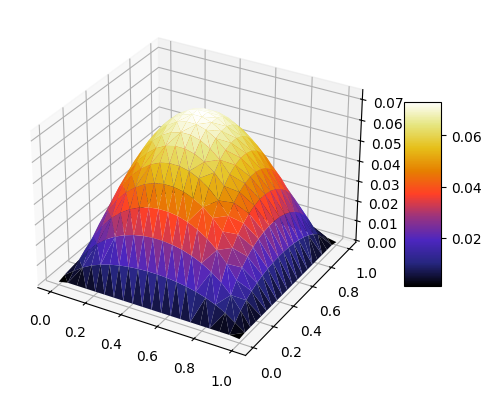

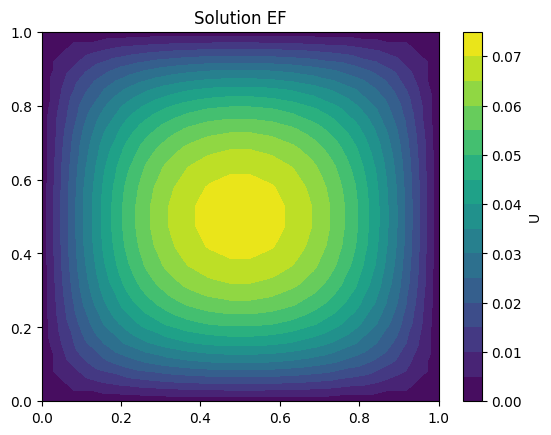

In [16]:
instance.solve('quad','carre','laplacien',plot=True)

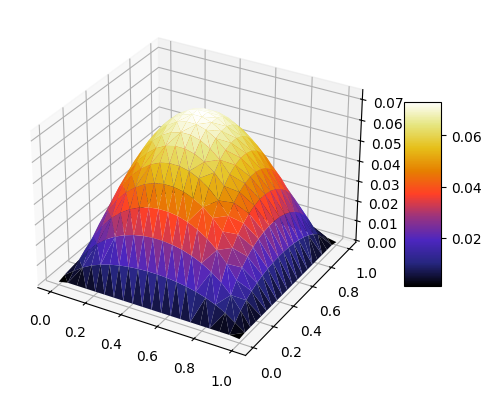

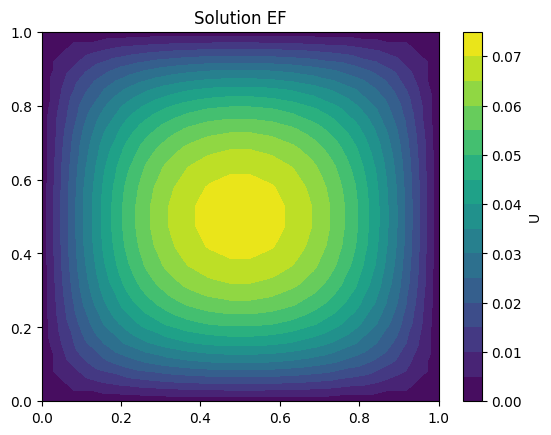

In [17]:
instance.solve('dirict','carre','laplacien',plot=True)

In [18]:
# Dans ce cas puisque la solution est unique on peut  calculer l'erreur et aussi ca donne une bonne resulatat 
x = np.array([coord[0] for coord in mesh.coords.values()])
y = np.array([coord[1] for coord in mesh.coords.values()])
def f(x,y):
    return 2*np.pi**2*np.sin(np.pi*x)*np.sin(np.pi*y)
# convertir en vecteur pour le produit scalaire
print('Resolution de - laplacien u = f')
F = f(x,y)
instance = Poisson(mesh, f)
instance.assemble_matrix()
# instance.dirichlet_conditions()
instance.conditions_on_borders({
    "bord": ("dirichlet", 0)
})
instance.rhss() 
instance.Smb(mesh,F)
instance.solve('quad','carre','laplacien')
instance.solve('dirict','carre','laplacien')
def function(x,y):
    return np.sin(np.pi*x)*np.sin(np.pi*y)
ue = function(x,y)
for i in [node-1 for node in mesh.neudes_bord]:
    ue[i] = 0
instance.compute(ue,'quad')
instance.compute(ue,'dirict')

Resolution de - laplacien u = f
nodes 400
Norme L2 = 2.45e-03
Norme H1 = 2.05e-02
Norme L2 = 1.16e-05
Norme H1 = 1.81e-02


## Rappel du système variationnel couplé

On a :

### 📘 VF1 – Équation de la pression :
$$
\int_{\Omega} \frac{\partial p}{\partial t} \cdot v\, dx
+ \kappa M \int_{\Omega} \nabla p \cdot \nabla v\, dx
= \beta_e M \int_{\Omega} \frac{\partial T}{\partial t} \cdot v\, dx
- k_{pT} M \int_{\Omega} \nabla T \cdot \nabla v\, dx
\tag{VF1}
$$
### 📘 VF2 – Équation de la température :
$$
\int_{\Omega} \frac{\partial T}{\partial t} \cdot w\, dx
+ \kappa_T \int_{\Omega} \nabla T \cdot \nabla w\, dx
= \frac{\beta_e}{m_d} \int_{\Omega} \frac{\partial p}{\partial t} \cdot w\, dx
- \kappa_{Tp} \int_{\Omega} \nabla p \cdot \nabla w\, dx
\tag{VF2}
$$




✅ **Objectif** : extraire toutes les matrices qui composent ce système

On suppose que :
- $\{\varphi_i\}_{i=1}^N$ est la base des fonctions test/interpolation (éléments finis P1),
- On cherche $p(x,t) = \sum p_i(t) \varphi_i(x)$, et pareil pour $T(x,t)$.

### 🧩 1. Matrices élémentaires de base

| Matrice | Définition mathématique | Nom usuel |
|---------|------------------------|-----------|
| **M**   | $M_{ij} = \int_{\Omega} \varphi_i \varphi_j\, dx$ | Masse |
| **K**   | $K_{ij} = \int_{\Omega} \nabla \varphi_i \cdot \nabla \varphi_j\, dx$ | Rigidité (diffusion) |

### 🧮 2. Matrices de dérivées en temps

On veut approximer les dérivées temporelles :  
$\frac{\partial p}{\partial t},\ \frac{\partial T}{\partial t}$

Dans la formulation variationnelle, elles donnent des termes de masse, multipliés par des coefficients.

- 🟩 a. Matrice $M_{pp}$ pour $\frac{\partial p}{\partial t} \cdot v$  
  $M_{pp} = \int_{\Omega} \varphi_i \varphi_j\, dx = M$

- 🟩 b. Matrice $M_{pT}$ pour $\frac{\partial T}{\partial t} \cdot v$  
  $M_{pT} = \beta_e M \cdot M$

- 🟩 c. Matrice $M_{Tp}$ pour $\frac{\partial p}{\partial t} \cdot w$  
  $M_{Tp} = \frac{\beta_e}{m_d} \cdot M$

- 🟩 d. Matrice $M_{TT}$ pour $\frac{\partial T}{\partial t} \cdot w$  
  $M_{TT} = M$


### 🧮 3. Matrices de diffusion (rigidité)

- 🔷 a. $A_{pp}$ : terme $\nabla p \cdot \nabla v$  
  $A_{pp} = \kappa M \cdot K$

- 🔷 b. $A_{pT}$ : terme $\nabla T \cdot \nabla v$  
  $A_{pT} = -k_{pT} M \cdot K$

- 🔷 c. $A_{TT}$ : terme $\nabla T \cdot \nabla w$  
  $A_{TT} = \kappa_T \cdot K$

- 🔷 d. $A_{Tp}$ : terme $\nabla p \cdot \nabla w$  
  $A_{Tp} = -\kappa_{Tp} \cdot K$


### 🧱 4. Matrices globales : formes blocs

- 🔶 **Matrice de masse couplée** $M_c$ :
$$
M_c =
\begin{bmatrix}
M & -\beta_e M \\
-\frac{\beta_e}{m_d} M & M
\end{bmatrix}
$$

- 🔶 **Matrice de rigidité couplée** $A_c$ :
$$
A_c =
\begin{bmatrix}
\kappa M K & -k_{pT} M K \\
-\kappa_{Tp} K & \kappa_T K
\end{bmatrix}
$$



### ✅ Forme finale du système (EDO vectorielle)

$$
M_c \cdot \frac{d}{dt}
\begin{bmatrix}
p(t) \\
T(t)
\end{bmatrix}
+ A_c \cdot
\begin{bmatrix}
p(t) \\
T(t)
\end{bmatrix}
= 0
$$

### 🧮 3. Matrices de diffusion (rigidité)

- 🔷 a. $A_{pp}$ : terme $\nabla p \cdot \nabla v$  
  $A_{pp} = \kappa M \cdot K$

- 🔷 b. $A_{pT}$ : terme $\nabla T \cdot \nabla v$  
  $A_{pT} = -k_{pT} M \cdot K$

- 🔷 c. $A_{TT}$ : terme $\nabla T \cdot \nabla w$  
  $A_{TT} = \kappa_T \cdot K$

- 🔷 d. $A_{Tp}$ : terme $\nabla p \cdot \nabla w$  
  $A_{Tp} = -\kappa_{Tp} \cdot K$



### 🧮 2. Matrices de dérivées en temps

On veut approximer les dérivées temporelles :  
$\frac{\partial p}{\partial t},\ \frac{\partial T}{\partial t}$

Dans la formulation variationnelle, elles donnent des termes de masse, multipliés par des coefficients.

- 🟩 a. Matrice $M_{pp}$ pour $\frac{\partial p}{\partial t} \cdot v$  
  $M_{pp} = \int_{\Omega} \varphi_i \varphi_j\, dx = M$

- 🟩 b. Matrice $M_{pT}$ pour $\frac{\partial T}{\partial t} \cdot v$  
  $M_{pT} = \beta_e M \cdot M$

- 🟩 c. Matrice $M_{Tp}$ pour $\frac{\partial p}{\partial t} \cdot w$  
  $M_{Tp} = \frac{\beta_e}{m_d} \cdot M$

- 🟩 d. Matrice $M_{TT}$ pour $\frac{\partial T}{\partial t} \cdot w$  
  $M_{TT} = M$

In [19]:
# Constantes physiques pour la modélisation thermo-hydraulique couplée

# Diffusivité de pression (m²/s)
cp = 1e-3  # [m²/s]

# Diffusivité thermique (m²/s)
cT = 1e-4  # [m²/s]

# Couplage thermo-hydraulique (pression due au gradient de température)
lambda_pT = 20  # [MPa / (K·s)]

# Couplage hydraulique-thermique (température due au gradient de pression)
lambda_Tp = 0.01  # [K / (MPa·s)]

# Geo 1:

In [20]:
from GmeshRead import mesh2d
mesh = mesh2d("./maillage/trous_puits.msh")
mesh.process()
x = np.array([coord[0] for coord in mesh.coords.values()])
y = np.array([coord[1] for coord in mesh.coords.values()])

In [21]:
# la matrice App et Atp
instance = Poisson(mesh, f)
instance.assemble_matrix()
instance.conditions_on_borders({
    "bord": ("neumann", 0),
    "PuitsInj": ("dirichlet", 0),  # exemple : flux de Neumann = 5
    "PuitsExt": ("dirichlet", 0)   # exemple : flux de Neumann = 5
})
A_pp = cp * instance.M
M_pp = instance.D
M_pt = lambda_pT * instance.D



nodes 2264


In [22]:
# la matrice Att et Apt 
instance = Poisson(mesh, f)
instance.assemble_matrix()
instance.conditions_on_borders({
    "bord": ("neumann", 0),
    "PuitsInj": ("dirichlet", 293),  # exemple : flux de Neumann = 5
    "PuitsExt": ("neumann", 0)   # exemple : flux de Neumann = 5
})
A_tt = cT * instance.M
M_tt = instance.D
M_tp = lambda_Tp * instance.D

nodes 2264


In [23]:
M_pp = csc_matrix(M_pp)
M_pt = csc_matrix(M_pt)
M_tp = csc_matrix(M_tp)
M_tt = csc_matrix(M_tt)
A_pp = csc_matrix(A_pp)
A_tt = csc_matrix(A_tt)
N = A_tt.shape[0]
zero = csc_matrix((N, N))
# Matrice de masse couplée
M_c = bmat([
    [M_tt, -M_tp],
    [-M_pt, M_pp]
]).tocsc()

# Matrice de rigidité couplée
A_c = bmat([
    [A_tt, zero],
    [zero, A_pp]
]).tocsc()

# With variation

In [24]:
# La methode pour calculer les iteration du temps avec la methode de Euler explicite dans ce cas 
def mul(b, A, x):
    b[:] = A @ x 

def euler_im_loop(u_temp, S, u, Nt,Nx, p_inj_nodes, T_inj_nodes,p_ext_nodes):
    for n in range(Nt):
        mul(u_temp, S, u)
        for i in p_inj_nodes:
            u_temp[i - 1 + Nx//2] = 2#51  # ou la valeur désirée
        for i in p_ext_nodes:
            u_temp[i - 1 + Nx//2] = -1#48
        for i in T_inj_nodes:
           u_temp[i - 1] = -130 + 273.15
        u[:] = u_temp

def euler_im(u0, Nx, T, Nt, A, M, p_inj_nodes, T_inj_nodes, p_ext_nodes):
    dt = T / Nt
    M = np.linalg.inv(M.toarray())
    S = np.identity(Nx) + dt * (M @ A)
    S = np.linalg.inv(S)
    u = u0.copy()
    u_temp = np.empty_like(u)
    euler_im_loop(u_temp, S, u, Nt,Nx, p_inj_nodes, T_inj_nodes, p_ext_nodes)
    return u

In [25]:
p0 = np.full(instance.Ndof, 0.)  # exemple pression initiale 49
T0 = np.full(instance.Ndof, 273.15)  # exemple température initiale 150 + 273.15
p_inj_nodes = mesh.get_border_points_by_name("PuitsInj")
p_ext_nodes = mesh.get_border_points_by_name("PuitsExt")
T_inj_nodes = mesh.get_border_points_by_name("PuitsInj")
Nx =  M_c.shape[0]
# Appliquer les valeurs sur les noeuds d'injection/extraction
for i in p_inj_nodes:
    p0[i - 1] = 2#51  # ou la valeur désirée
for i in p_ext_nodes:
    p0[i - 1] = -1#48
for i in T_inj_nodes:
    T0[i - 1] = -130 + 273.15#20 + 273.15  # ou la valeur désirée

F = np.concatenate([T0, p0])
Nt=1000
T= [30*86400,6*30*86400,365*86400,3*365*86400,10*365*86400]
# u = euler_ex(F, Nx, T, Nt, A_c,M_c, p_inj_nodes, T_inj_nodes, p_ext_nodes)

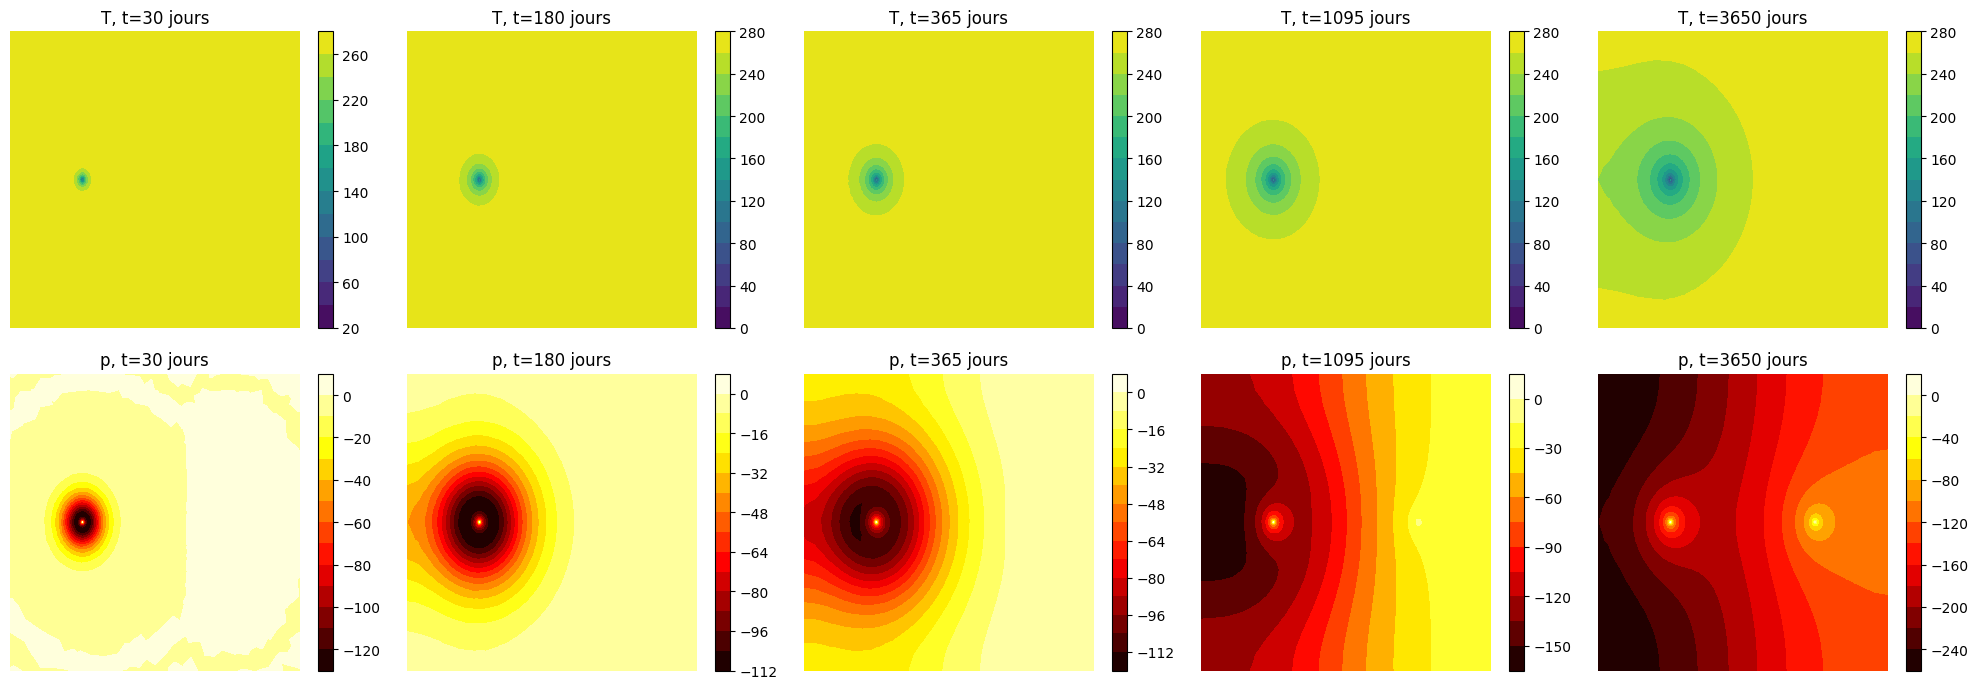

In [26]:
results = []
for t in T:
    u = euler_im(F, Nx, t, Nt, A_c, M_c, p_inj_nodes, T_inj_nodes, p_ext_nodes)
    results.append(u.copy())

fig, axes = plt.subplots(2, 5, figsize=(20, 7))

for i, tval in enumerate(T):
    T_sol = results[i][:N]
    p_sol = results[i][N:2*N]
    # Température (ligne 0)
    axT = axes[0, i]
    tcfT = axT.tricontourf(x, y, T_sol, levels=14, cmap='viridis')
    fig.colorbar(tcfT, ax=axT)
    axT.set_title(f"T, t={tval/86400:.0f} jours")
    axT.axis('off')
    # Pression (ligne 1)
    axP = axes[1, i]
    tcfP = axP.tricontourf(x, y, p_sol, levels=14, cmap='hot')
    fig.colorbar(tcfP, ax=axP)
    axP.set_title(f"p, t={tval/86400:.0f} jours")
    axP.axis('off')

axes[0,0].set_ylabel("Température")
axes[1,0].set_ylabel("Pression")
plt.tight_layout()
# Enregistrer la figure dans le dossier /report/Image
plt.savefig("./report/Image/solution_couplée.png", dpi=300, bbox_inches='tight')
plt.show()

<!-- ## Pression Equation 
$$
\frac{\partial p}{\partial t} - \kappa M \nabla^2 p = \beta_e M \frac{\partial T}{\partial t} + k_{pT} M \nabla^2 T
$$

$$
\frac{Pa}{s} \quad - \quad \frac{Pa^2}{s} \quad = \quad \frac{Pa}{s} \quad + \quad \frac{Pa}{s}
$$

## Temperature Equation
$$
\frac{\partial T}{\partial t} - \kappa_T \nabla^2 T = \frac{\beta_e}{m_d} \frac{\partial p}{\partial t} + \kappa_{Tp} \nabla^2 p
$$

$$
\frac{K}{s} \quad - \quad \frac{K}{s} \quad = \quad \frac{Pa}{K \cdot s} \quad + \quad \frac{K}{s}
$$ -->


# With T0

In [27]:
# La methode pour calculer les iteration du temps avec la methode de Euler explicite dans ce cas 
def mul(b, A, x):
    b[:] = A @ x 

def euler_im_loop(u_temp, S, u, Nt,Nx, p_inj_nodes, T_inj_nodes,p_ext_nodes):
    for n in range(Nt):
        mul(u_temp, S, u)
        for i in p_inj_nodes:
            u_temp[i - 1 + Nx//2] = 51  # ou la valeur désirée
        for i in p_ext_nodes:
            u_temp[i - 1 + Nx//2] = 48
        for i in T_inj_nodes:
           u_temp[i - 1] = 293.15  # ou la valeur désirée
        u[:] = u_temp

def euler_im(u0, Nx, T, Nt, A, M, p_inj_nodes, T_inj_nodes, p_ext_nodes):
    
    dt = T / Nt
    M = np.linalg.inv(M.toarray())
    S = np.identity(Nx) + dt * (M @ A)
    S = np.linalg.inv(S)
    u = u0.copy()
    u_temp = np.empty_like(u)
    euler_im_loop(u_temp, S, u, Nt,Nx, p_inj_nodes, T_inj_nodes, p_ext_nodes)
    return u

p0 = np.full(instance.Ndof, 49.5)  # exemple pression initiale 49
T0 = np.full(instance.Ndof, 150+273.15)  # exemple température initiale 150 + 273.15
p_inj_nodes = mesh.get_border_points_by_name("PuitsInj")
p_ext_nodes = mesh.get_border_points_by_name("PuitsExt")
T_inj_nodes = mesh.get_border_points_by_name("PuitsInj")

Nx =  M_c.shape[0]
# alpha est la diffusivité thermique du matériau (une constante positive)  
alpha = 1.0 
# Appliquer les valeurs sur les noeuds d'injection/extraction
for i in p_inj_nodes:
    p0[i - 1] = 51  # ou la valeur désirée
for i in p_ext_nodes:
    p0[i - 1] = 48
for i in T_inj_nodes:
    T0[i - 1] = 293.15  # ou la valeur désirée

F = np.concatenate([T0, p0])
Nt=1000
T= [30*86400,6*30*86400,365*86400,3*365*86400,10*365*86400]
# u = euler_im(F, Nx, T, Nt, A_c, M_c, p_inj_nodes, T_inj_nodes, p_ext_nodes)

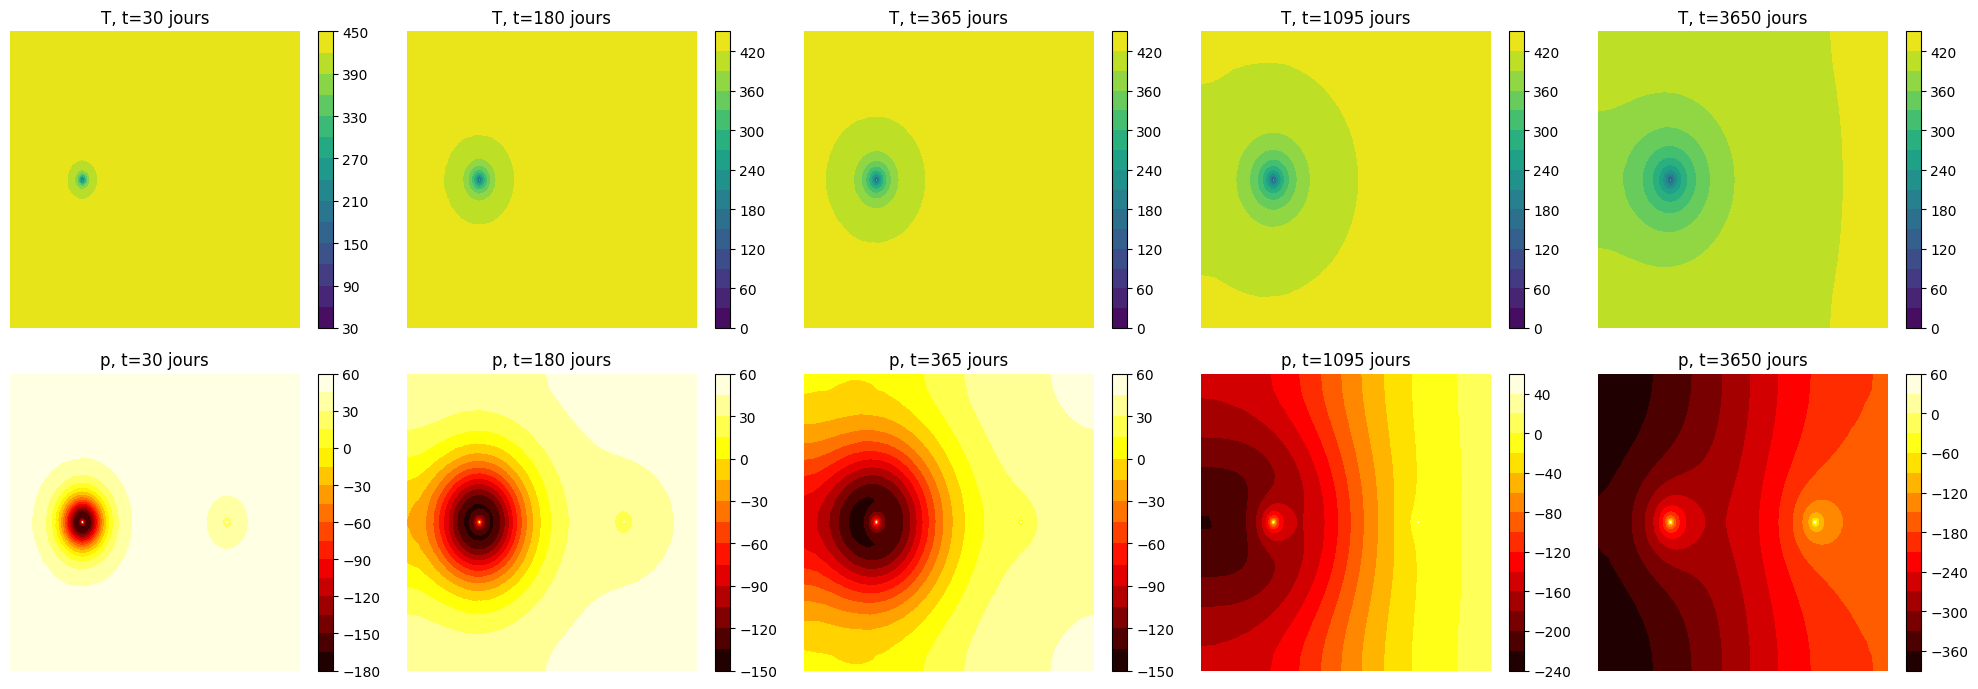

In [28]:
results = []
for t in T:
    u = euler_im(F, Nx, t, Nt, A_c, M_c, p_inj_nodes, T_inj_nodes, p_ext_nodes)
    results.append(u.copy())

fig, axes = plt.subplots(2, 5, figsize=(20, 7))

for i, tval in enumerate(T):
    T_sol = results[i][:N]
    p_sol = results[i][N:2*N]
    # Température (ligne 0)
    axT = axes[0, i]
    tcfT = axT.tricontourf(x, y, T_sol, levels=14, cmap='viridis')
    fig.colorbar(tcfT, ax=axT)
    axT.set_title(f"T, t={tval/86400:.0f} jours")
    axT.axis('off')
    # Pression (ligne 1)
    axP = axes[1, i]
    tcfP = axP.tricontourf(x, y, p_sol, levels=14, cmap='hot')
    fig.colorbar(tcfP, ax=axP)
    axP.set_title(f"p, t={tval/86400:.0f} jours")
    axP.axis('off')

axes[0,0].set_ylabel("Température")
axes[1,0].set_ylabel("Pression")
plt.tight_layout()
plt.show()

# Theta methode


## Discrétisation en temps (schéma θ)

Partant du problème général :
$$
M \dot{U} + A U = 0,
$$

on applique le schéma de discrétisation en temps de type θ :
$$
M \frac{U^{n+1} - U^n}{\Delta t} + A \left[ \theta U^{n+1} + (1-\theta) U^n \right] = 0.
$$

Ce qui s’écrit :
$$
M (U^{n+1} - U^n) + \Delta t\, A \left[ \theta U^{n+1} + (1-\theta) U^n \right] = 0.
$$

Finalement, on obtient le système à résoudre à chaque pas de temps :
$$
\left[ M + \Delta t\, \theta A \right] U^{n+1} = \left[ M - \Delta t\, (1-\theta) A \right] U^n.
$$

In [29]:
# La methode pour calculer les iteration du temps avec la methode de Euler explicite dans ce cas 
def mul(b, A, x):
    b[:] = A @ x 

def euler_th_loop(u_temp, S, u, Nt,Nx, p_inj_nodes, T_inj_nodes,p_ext_nodes):
    for n in range(Nt):
        mul(u_temp, S, u)
        for i in p_inj_nodes:
            u_temp[i - 1 + Nx//2] = 51  # ou la valeur désirée
        for i in p_ext_nodes:
            u_temp[i - 1 + Nx//2] = 48
        for i in T_inj_nodes:
           u_temp[i - 1] = 293.15  # ou la valeur désirée
        u[:] = u_temp

def euler_th(u0, Nx, T, Nt, A, M, theta, p_inj_nodes, T_inj_nodes, p_ext_nodes):
    
    dt = T / Nt
    # M = M.toarray()
    # print("A shape:", A.shape, "type:", type(A))
    # print("M shape:", M.shape, "type:", type(M))
    Sd = M - dt * (1 - theta) * A
    Sg = M + dt * theta * A
    Sg = np.linalg.inv(Sg.toarray())
    S = Sg @ Sd
    u = u0.copy()
    u_temp = np.empty_like(u)
    euler_th_loop(u_temp, S, u, Nt, Nx, p_inj_nodes, T_inj_nodes, p_ext_nodes)
    return u

p0 = np.full(instance.Ndof, 49.5)  # exemple pression initiale 49
T0 = np.full(instance.Ndof, 150+273.15)  # exemple température initiale 150 + 273.15
p_inj_nodes = mesh.get_border_points_by_name("PuitsInj")
p_ext_nodes = mesh.get_border_points_by_name("PuitsExt")
T_inj_nodes = mesh.get_border_points_by_name("PuitsInj")

Nx =  M_c.shape[0]
# Appliquer les valeurs sur les noeuds d'injection/extraction
for i in p_inj_nodes:
    p0[i - 1] = 51  # ou la valeur désirée
for i in p_ext_nodes:
    p0[i - 1] = 48
for i in T_inj_nodes:
    T0[i - 1] = 293.15  # ou la valeur désirée

F = np.concatenate([T0, p0])
Nt=5000
theta = 0.5  # Choisir un theta entre 0 et 1
T= [30*86400,6*30*86400,365*86400,3*365*86400,10*365*86400]
# u = euler_im(F, Nx, T, Nt, A_c, M_c, p_inj_nodes, T_inj_nodes, p_ext_nodes)

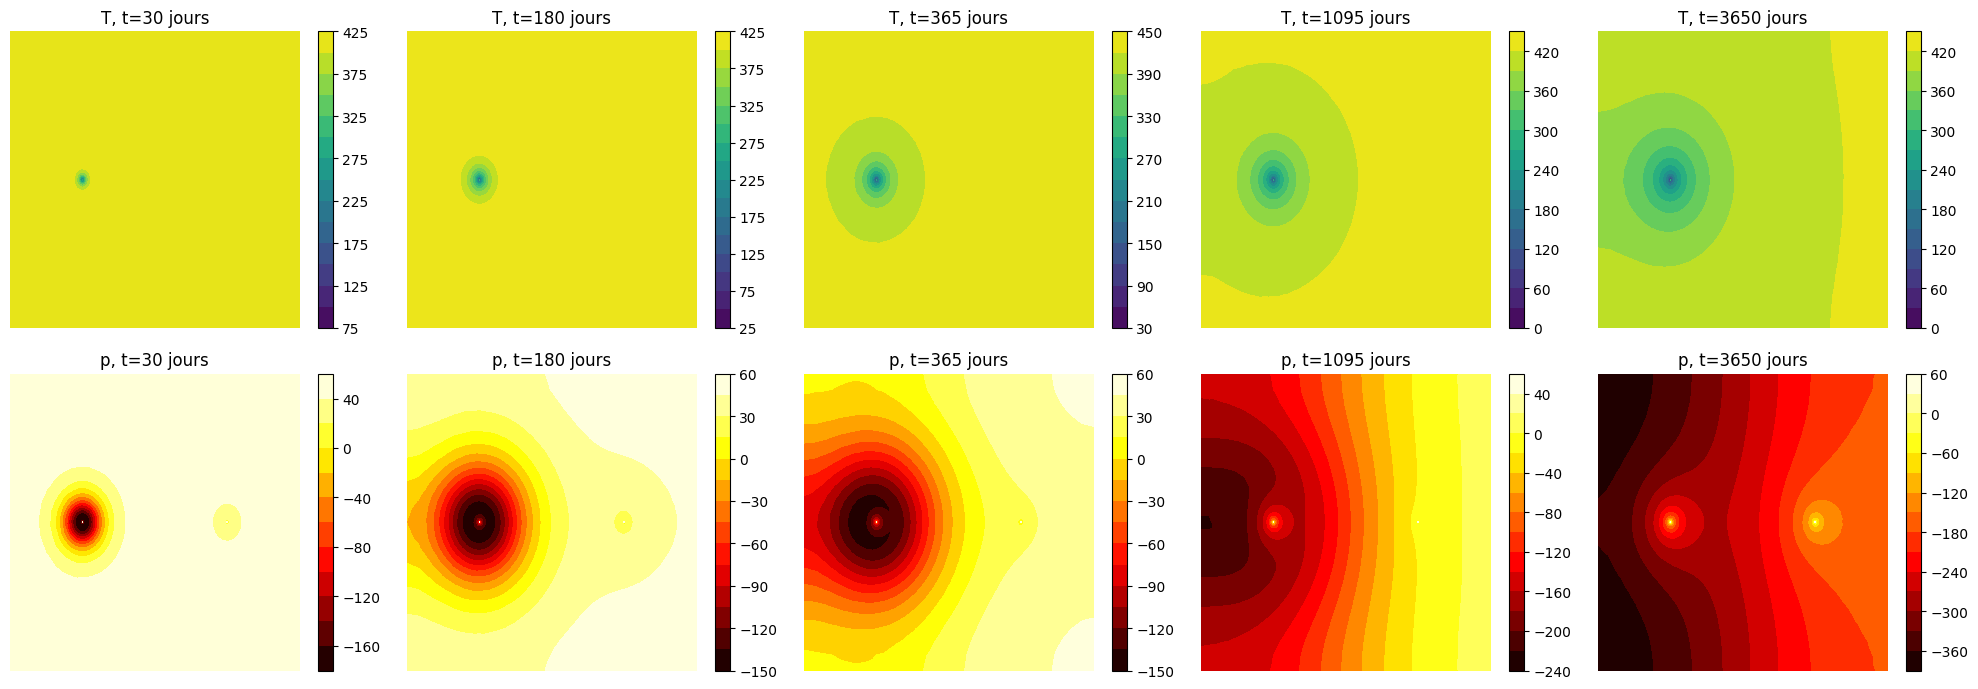

In [30]:
results = []
for t in T:
    u = euler_th(F, Nx, t, Nt, A_c, M_c, theta, p_inj_nodes, T_inj_nodes, p_ext_nodes)
    results.append(u.copy())

fig, axes = plt.subplots(2, 5, figsize=(20, 7))

for i, tval in enumerate(T):
    T_sol = results[i][:N]
    p_sol = results[i][N:2*N]
    # Température (ligne 0)
    axT = axes[0, i]
    tcfT = axT.tricontourf(x, y, T_sol, levels=14, cmap='viridis')
    fig.colorbar(tcfT, ax=axT)
    axT.set_title(f"T, t={tval/86400:.0f} jours")
    axT.axis('off')
    # Pression (ligne 1)
    axP = axes[1, i]
    tcfP = axP.tricontourf(x, y, p_sol, levels=14, cmap='hot')
    fig.colorbar(tcfP, ax=axP)
    axP.set_title(f"p, t={tval/86400:.0f} jours")
    axP.axis('off')

axes[0,0].set_ylabel("Température")
axes[1,0].set_ylabel("Pression")
plt.tight_layout()
plt.show()

# Geo2

In [31]:
from GmeshRead import mesh2d
mesh = mesh2d("./maillage/trous_line.msh")
mesh.process()
x = np.array([coord[0] for coord in mesh.coords.values()])
y = np.array([coord[1] for coord in mesh.coords.values()])

In [32]:
# la matrice App et Atp
instance = Poisson(mesh, f)
instance.assemble_matrix()
instance.conditions_on_borders({
    "bord": ("neumann", 0),
    "PuitsInj": ("dirichlet", 0),  # exemple : flux de Neumann = 5
    "PuitsExt": ("dirichlet", 0)   # exemple : flux de Neumann = 5
})
A_pp = cp * instance.M
M_pp = instance.D
M_pt = lambda_pT * instance.D


nodes 2228


In [33]:
# la matrice Att et Apt 
instance = Poisson(mesh, f)
instance.assemble_matrix()
instance.conditions_on_borders({
    "bord": ("neumann", 0),
    "PuitsInj": ("dirichlet", 293),  # exemple : flux de Neumann = 5
    "PuitsExt": ("neumann", 0)   # exemple : flux de Neumann = 5
})
A_tt = cT * instance.M
M_tt = instance.D
M_tp = lambda_Tp * instance.D

nodes 2228


In [34]:
M_pp = csc_matrix(M_pp)
M_pt = csc_matrix(M_pt)
M_tp = csc_matrix(M_tp)
M_tt = csc_matrix(M_tt)
A_pp = csc_matrix(A_pp)
A_tt = csc_matrix(A_tt)
N = A_tt.shape[0]
zero = csc_matrix((N, N))
# Matrice de masse couplée
M_c = bmat([
    [M_tt, -M_tp],
    [-M_pt, M_pp]
]).tocsc()

# Matrice de rigidité couplée
A_c = bmat([
    [A_tt, zero],
    [zero, A_pp]
]).tocsc()

# With variation

In [35]:
# La methode pour calculer les iteration du temps avec la methode de Euler explicite dans ce cas 
def mul(b, A, x):
    b[:] = A @ x 

def euler_im_loop(u_temp, S, u, Nt,Nx, p_inj_nodes, T_inj_nodes,p_ext_nodes):
    for n in range(Nt):
        mul(u_temp, S, u)
        for i in p_inj_nodes:
            u_temp[i - 1 + Nx//2] = 2#51  # ou la valeur désirée
        for i in p_ext_nodes:
            u_temp[i - 1 + Nx//2] = -1#48
        for i in T_inj_nodes:
           u_temp[i - 1] = -130 + 273.15
        u[:] = u_temp

def euler_im(u0, Nx, T, Nt, A, M, p_inj_nodes, T_inj_nodes, p_ext_nodes):
    dt = T / Nt
    M = np.linalg.inv(M.toarray())
    S = np.identity(Nx) + dt * (M @ A)
    S = np.linalg.inv(S)
    u = u0.copy()
    u_temp = np.empty_like(u)
    euler_im_loop(u_temp, S, u, Nt,Nx, p_inj_nodes, T_inj_nodes, p_ext_nodes)
    return u

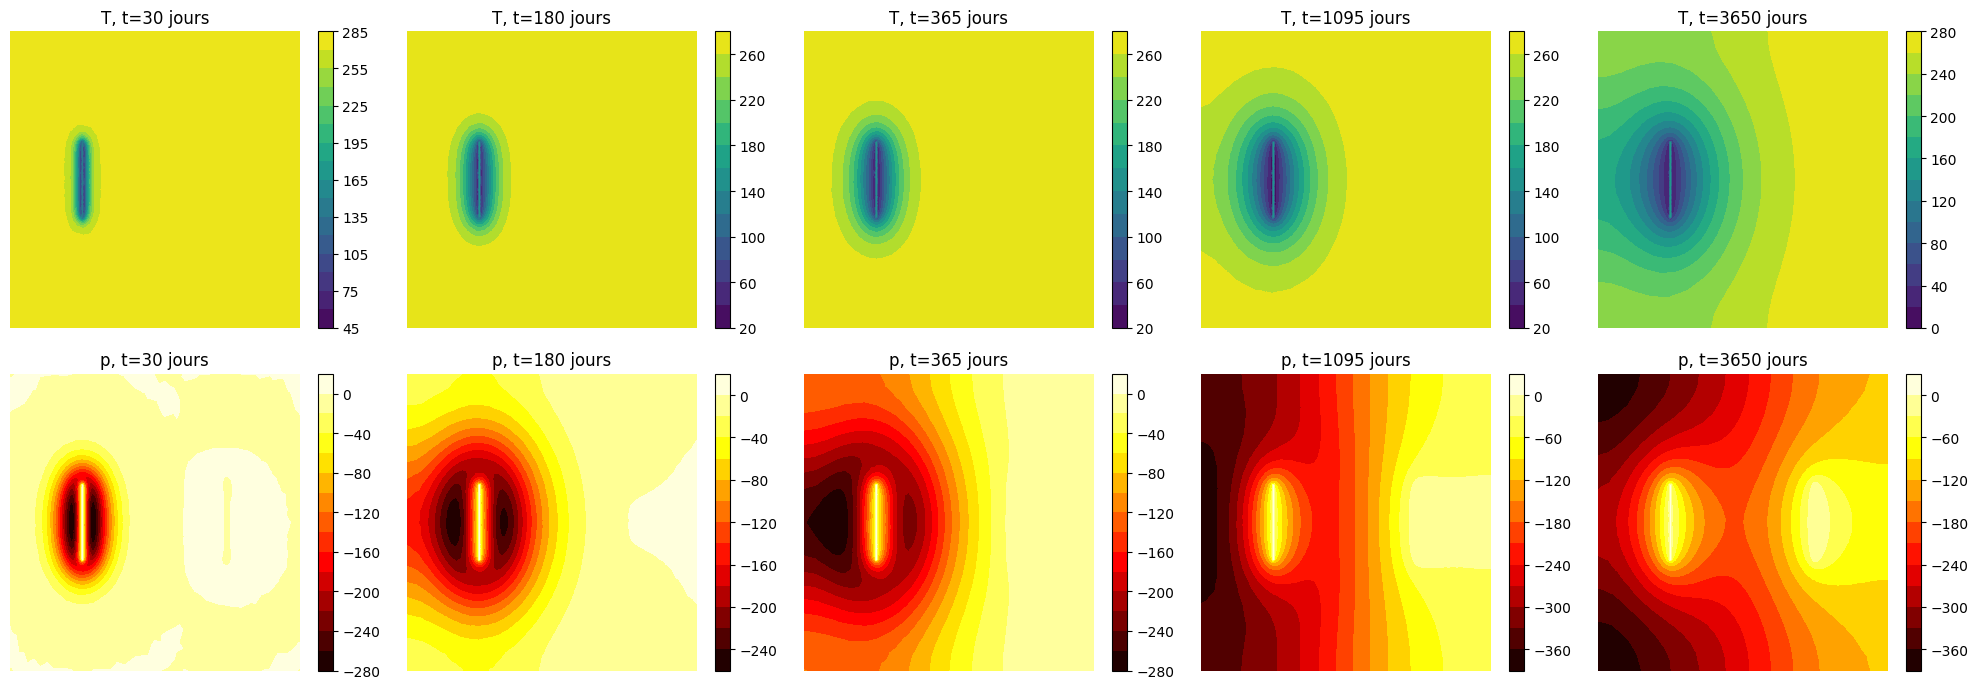

In [36]:
p0 = np.full(instance.Ndof, 0.)  # exemple pression initiale 49
T0 = np.full(instance.Ndof, 273.15)  # exemple température initiale 150 + 273.15
p_inj_nodes = mesh.get_border_points_by_name("PuitsInj")
p_ext_nodes = mesh.get_border_points_by_name("PuitsExt")
T_inj_nodes = mesh.get_border_points_by_name("PuitsInj")
Nx =  M_c.shape[0]
# Appliquer les valeurs sur les noeuds d'injection/extraction
for i in p_inj_nodes:
    p0[i - 1] = 2#51  # ou la valeur désirée
for i in p_ext_nodes:
    p0[i - 1] = -1#48
for i in T_inj_nodes:
    T0[i - 1] = -130 + 273.15#20 + 273.15  # ou la valeur désirée

F = np.concatenate([T0, p0])
Nt=1000
T= [30*86400,6*30*86400,365*86400,3*365*86400,10*365*86400]
results = []
for t in T:
    u = euler_im(F, Nx, t, Nt, A_c, M_c, p_inj_nodes, T_inj_nodes, p_ext_nodes)
    results.append(u.copy())

fig, axes = plt.subplots(2, 5, figsize=(20, 7))

for i, tval in enumerate(T):
    T_sol = results[i][:N]
    p_sol = results[i][N:2*N]
    # Température (ligne 0)
    axT = axes[0, i]
    tcfT = axT.tricontourf(x, y, T_sol, levels=14, cmap='viridis')
    fig.colorbar(tcfT, ax=axT)
    axT.set_title(f"T, t={tval/86400:.0f} jours")
    axT.axis('off')
    # Pression (ligne 1)
    axP = axes[1, i]
    tcfP = axP.tricontourf(x, y, p_sol, levels=14, cmap='hot')
    fig.colorbar(tcfP, ax=axP)
    axP.set_title(f"p, t={tval/86400:.0f} jours")
    axP.axis('off')

axes[0,0].set_ylabel("Température")
axes[1,0].set_ylabel("Pression")
plt.tight_layout()
plt.show()

# With T0

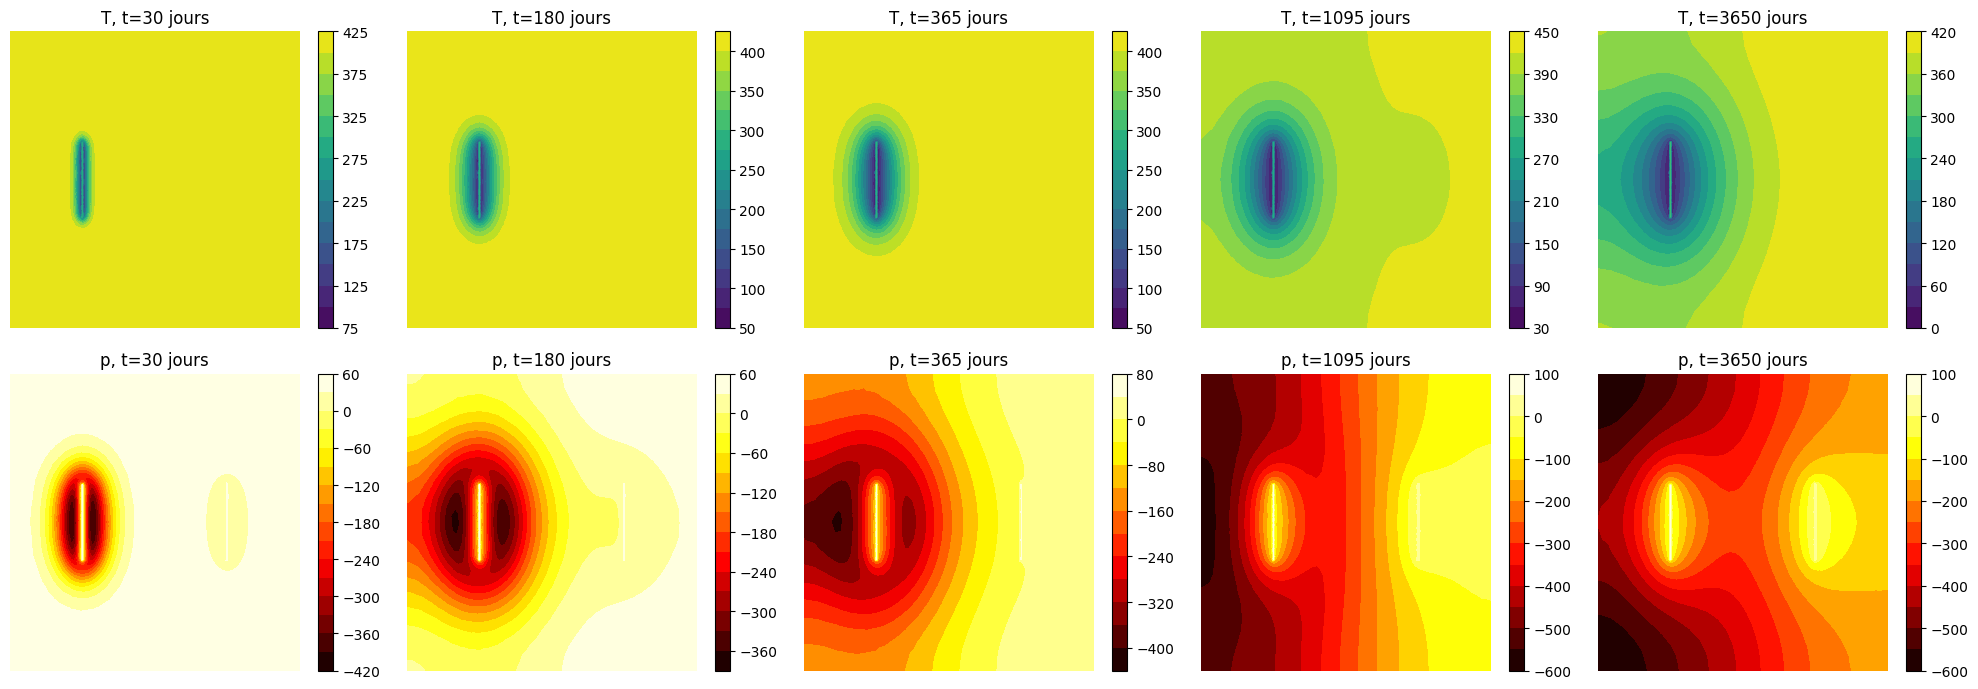

In [37]:
# La methode pour calculer les iteration du temps avec la methode de Euler explicite dans ce cas 
def mul(b, A, x):
    b[:] = A @ x 

def euler_im_loop(u_temp, S, u, Nt,Nx, p_inj_nodes, T_inj_nodes,p_ext_nodes):
    for n in range(Nt):
        mul(u_temp, S, u)
        for i in p_inj_nodes:
            u_temp[i - 1 + Nx//2] = 51  # ou la valeur désirée
        for i in p_ext_nodes:
            u_temp[i - 1 + Nx//2] = 48
        for i in T_inj_nodes:
           u_temp[i - 1] = 293.15  # ou la valeur désirée
        u[:] = u_temp

def euler_im(u0, Nx, T, Nt, A, M, p_inj_nodes, T_inj_nodes, p_ext_nodes):
    
    dt = T / Nt
    M = np.linalg.inv(M.toarray())
    S = np.identity(Nx) + dt * (M @ A)
    S = np.linalg.inv(S)
    u = u0.copy()
    u_temp = np.empty_like(u)
    euler_im_loop(u_temp, S, u, Nt,Nx, p_inj_nodes, T_inj_nodes, p_ext_nodes)
    return u

p0 = np.full(instance.Ndof, 49.5)  # exemple pression initiale 49
T0 = np.full(instance.Ndof, 150+273.15)  # exemple température initiale 150 + 273.15
p_inj_nodes = mesh.get_border_points_by_name("PuitsInj")
p_ext_nodes = mesh.get_border_points_by_name("PuitsExt")
T_inj_nodes = mesh.get_border_points_by_name("PuitsInj")

Nx =  M_c.shape[0]
# alpha est la diffusivité thermique du matériau (une constante positive)  
alpha = 1.0 
# Appliquer les valeurs sur les noeuds d'injection/extraction
for i in p_inj_nodes:
    p0[i - 1] = 51  # ou la valeur désirée
for i in p_ext_nodes:
    p0[i - 1] = 48
for i in T_inj_nodes:
    T0[i - 1] = 293.15  # ou la valeur désirée

F = np.concatenate([T0, p0])
Nt=1000
T= [30*86400,6*30*86400,365*86400,3*365*86400,10*365*86400]
results = []
for t in T:
    u = euler_im(F, Nx, t, Nt, A_c, M_c, p_inj_nodes, T_inj_nodes, p_ext_nodes)
    results.append(u.copy())

fig, axes = plt.subplots(2, 5, figsize=(20, 7))

for i, tval in enumerate(T):
    T_sol = results[i][:N]
    p_sol = results[i][N:2*N]
    # Température (ligne 0)
    axT = axes[0, i]
    tcfT = axT.tricontourf(x, y, T_sol, levels=14, cmap='viridis')
    fig.colorbar(tcfT, ax=axT)
    axT.set_title(f"T, t={tval/86400:.0f} jours")
    axT.axis('off')
    # Pression (ligne 1)
    axP = axes[1, i]
    tcfP = axP.tricontourf(x, y, p_sol, levels=14, cmap='hot')
    fig.colorbar(tcfP, ax=axP)
    axP.set_title(f"p, t={tval/86400:.0f} jours")
    axP.axis('off')

axes[0,0].set_ylabel("Température")
axes[1,0].set_ylabel("Pression")
plt.tight_layout()
plt.show()